In [1]:
%load_ext autoreload
%autoreload 2

In [167]:
import sys
sys.path.append('..')
from data_loaders import DataBlob
from utils import featurize, update_vars
import scanpy as sc
from modules.vae import GraphVAE, JointVAE, NonSpatialVAE, SpatialVAE
from torch import optim
from modules.losses import LossKZCP, Loss, Lossv2
from early_stopping import EarlyStopping
from tqdm import tqdm
import numpy as np
import seaborn as sns
import torch
from utils import clr_normalize_each_cell
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.preprocessing import scale
from scipy.stats import spearmanr
import umap.umap_ as umap
import squidpy as sq
import math
from leiden_clustering import LeidenClustering
from anndata import AnnData
warnings.filterwarnings('ignore')

In [168]:
def distance(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

In [19]:
dataset = DataBlob()

Injesting Data...: 100%|██████████| 4/4 [00:17<00:00,  4.47s/it]
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not

In [281]:
def reduce(data, labels):
    datax = []
    n_neighbors = None
    for i, (dat, lab) in enumerate(zip(data, labels)):
        if i == 0 or separate_dim:
            red = cuml.UMAP(
                n_components=2,
                n_neighbors=min(200, dat.shape[0] - 1) if n_neighbors is None else n_neighbors,
                min_dist=.5,
                random_state=42)

            red.fit(np.concatenate(data, axis=0))
        plot_data = red.transform(dat)
        datax.append(plot_data)

In [416]:
import cuml

def plot_latent(
    data,
    labels,
    names=None,
    legend=False,
    remove_outliers=False,
    n_components=2,
    separate_dim=False,
    square=False,
    method='umap',
    n_neighbors=None,
    seed=42,
    reduce_only=False
):
    method_names = {'pca': 'PC', 'umap': 'UMAP'}
    axs = []
    datax = []
    
    plt.rcParams['figure.figsize'] = (16, 8)

    for i, (dat, lab) in enumerate(zip(data, labels)):
        ax = plt.gcf().add_subplot(1, len(data), i+1, projection=None)
        axs.append(ax)
        if i == 0 or separate_dim:
            red = cuml.UMAP(
                n_components=n_components,
                n_neighbors=min(200, dat.shape[0] - 1) if n_neighbors is None else n_neighbors,
                min_dist=.5,
                random_state=seed)
            if separate_dim:
                red.fit(dat)
            else:
                red.fit(np.concatenate(data, axis=0))
        plot_data = red.transform(dat)
        datax.append(plot_data)
        
        if remove_outliers:
            filter = outliers(plot_data)
        for l in np.unique(np.concatenate(labels)):
            data_subset = np.transpose(plot_data[lab == l])
            if remove_outliers:
                data_subset[~filter[lab == l].T] = np.nan
            # ax.scatter(*data_subset, s=3e3*(1/dat.shape[0]), label=l)
            ax.scatter(*data_subset, s=55, label=l, edgecolors='black')
            
        if i == 1 and legend:
            ax.legend()
        if names is not None:
            ax.set_title(names[i])
        ax.set_xlabel(f'{method_names[method]}-1')
        ax.set_ylabel(f'{method_names[method]}-2')
        if n_components == 2 and square:
            ax.set_aspect('equal')
        elif n_components == 3:
            ax.set_zlabel(f'{method_names[method]}-3')
            if square:
                # https://stackoverflow.com/a/13701747
                X, Y, Z = np.transpose(plot_data)
                # Create cubic bounding box to simulate equal aspect ratio
                max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max()
                Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(X.max()+X.min())
                Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(Y.max()+Y.min())
                Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(Z.max()+Z.min())
                for xb, yb, zb in zip(Xb, Yb, Zb):
                    ax.plot([xb], [yb], [zb], 'w')
                    
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        
    if not separate_dim:
        axs_xlim = np.array([ax.get_xlim() for ax in axs])
        axs_ylim = np.array([ax.get_ylim() for ax in axs])
        new_xlim = (axs_xlim.min(axis=0)[0], axs_xlim.max(axis=0)[1])
        new_ylim = (axs_ylim.min(axis=0)[0], axs_ylim.max(axis=0)[1])
        for ax in axs:
            ax.set_xlim(new_xlim)
            ax.set_ylim(new_ylim)
            
    if reduce_only:
        plt.close()
    else:
        plt.show()
    return datax

In [110]:
adata = dataset[3] 
sc.pp.filter_genes(adata, min_counts=5)
sc.pp.filter_cells(adata, min_counts=5)
pdata = adata.uns['protein']
pdata.obsm['spatial'] = adata.obsm['spatial']
pdata.raw = pdata
pdata.X = pdata.X.astype(float)
data11 = adata.X.toarray()
data12 = pdata.X.toarray()

sc.tl.pca(pdata)
sc.pp.neighbors(pdata)
sc.tl.leiden(pdata, resolution=0.3)

type1 = pdata.obs.leiden.values
type2 = pdata.obs.leiden.values

In [456]:
gex = featurize(adata, pca_dim=1024)
pex = featurize(pdata, pca_dim=1024, clr=True)
# d11, d12 = gex.features_pca.cpu().numpy(), pex.features_pca.cpu().numpy()
d11, d12 = gex.features.cpu().numpy(), pex.features.cpu().numpy()

corr = torch.eye(d11.shape[0], d12.shape[0]).cuda()
# d11 = torch.tensor(d11).float().cuda()
# d12 = torch.tensor(d12).float().cuda()
d11.shape, d12.shape

((1303, 13317), (1303, 196))

In [443]:
from sklearn.decomposition import PCA

In [457]:
d11_pca = PCA(n_components=196).fit_transform(d11)
d12_pca = PCA(n_components=196).fit_transform(d12)

In [458]:
d11 = torch.tensor(d11_pca).cuda()
d12 = torch.tensor(d12_pca).cuda()

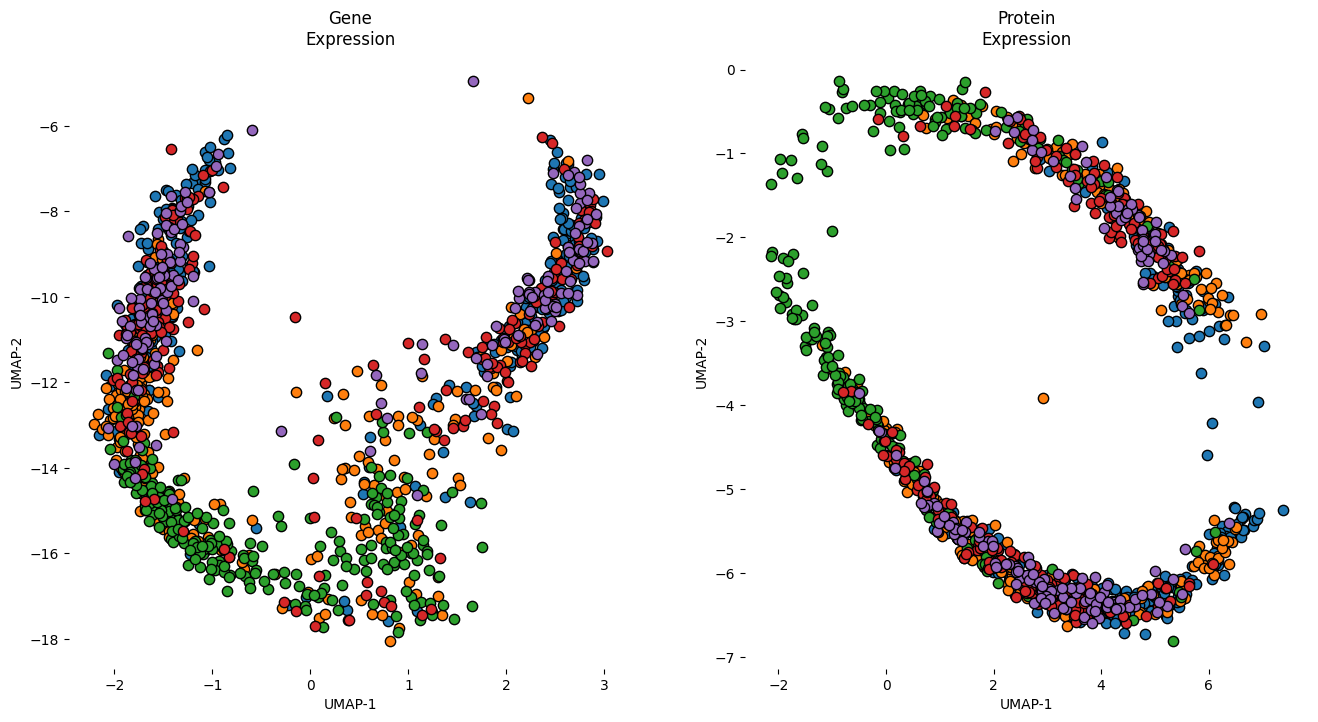

In [459]:
xyp, xyg = plot_latent([d11.cpu().numpy(), d12.cpu().numpy()], [type1, type2], 
            ['Gene\nExpression', 'Protein\nExpression'], 
            legend=False, method='umap',
            separate_dim=True);

In [531]:
model = SpatialVAE([d11.shape[1], d12.shape[1]], 32).cuda()
optimizer = optim.Adam(model.parameters(), lr=2e-3, weight_decay=0)
loss_func = Lossv2()
loss_func.alpha = {
    'kl_gex': 1e-18,
    'kl_pex': 1e-18,
    'recons_gex': 1e-1,
    'recons_pex': 1e-1,
    'cosine': 1e-3,
    'consistency': 0,
    'adj': 1e-8,
    'spatial': 1e-10,
    'alignment': 1e-8
}

In [532]:
es = EarlyStopping(patience=200, verbose=False, delta=1e-3, path='gvae.pth')
epochs = 15000
losses = []
oracle = []
embeds = []
feats = d11.data.cpu().numpy()

with tqdm(total=epochs) as pbar:
    for e in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X=[d11, d12], A=gex.adj_norm, corr=corr)
        output.epochs = epochs
        output.gex_features_pca = d11
        output.adj_label = gex.adj_label
        output.pos_weight = gex.pos_weight
        output.gex_sp_dist = gex.sp_dists
        output.corr = gex.adj_label
        
        output.norm = gex.norm
        
        output.pex_features_pca = d12
        loss = loss_func.compute(e, output)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        
        losses.append(float(loss))
        
        # es(np.mean(losses), model)   

        # if es.early_stop:
        #     break
        
        if e == 0 or e % 100 == 0:
            a = output.gex_recons.data.cpu().numpy()
            cor_mean = np.mean([spearmanr(feats[:, ixs], a[:, ixs]).statistic for ixs in range(a.shape[1])])
        
        model.eval()
            
        proteins = model.decoders[1](model.fc_mus[0](model.encoders[0](d11, gex.adj_norm), gex.adj_norm))
        corrsx = []
        c = proteins.detach().cpu().numpy()
        d = d12.cpu().numpy()

        for ixs in range(d.shape[1]):
            corrsx.append(spearmanr(d[:, ixs], c[:, ixs]).statistic)   
        oracle.append(np.mean(corrsx))
        pbar.update()

        pbar.set_description(f'Oracle: {np.mean(oracle):.3f} | Corr: {cor_mean:.3f} | Loss: {np.mean(losses):.3e} | Align: {loss_func.mean_align:.3e} | Cosine: {loss_func.mean_cosine:.3e} \
| Spatial: {loss_func.mean_spatial:.3e} | Adj: {loss_func.mean_adj:.3e} | MSE_Gex: {loss_func.mean_recons_gex:.3e} | MSE_Pex: {loss_func.mean_recons_pex:.3e}')

Oracle: 0.570 | Corr: 0.772 | Loss: 5.491e-03 | Align: 2.529e-08 | Cosine: 1.595e-03 | Spatial: 1.205e-09 | Adj: 1.571e-07 | MSE_Gex: 2.765e-03 | MSE_Pex: 1.131e-03: 100%|██████████| 15000/15000 [33:55<00:00,  7.37it/s]


In [536]:
model.eval()
integrated_data =  model(X=[d11, d12], A=gex.adj_norm, corr=corr)
gex_z = integrated_data.gex_z.data.cpu().numpy()
pex_z = integrated_data.pex_z.data.cpu().numpy()

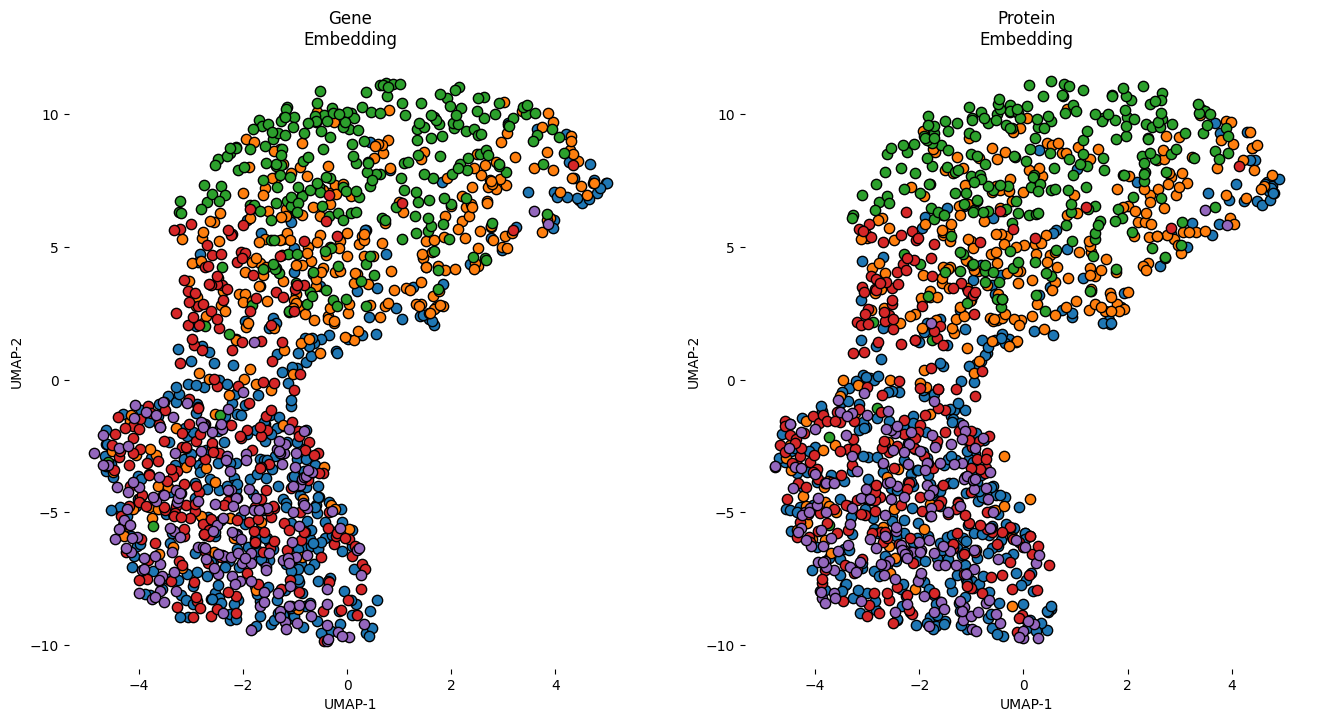

In [537]:
a, b = plot_latent([gex_z, pex_z], [type1, type2], 
            ['Gene\nEmbedding', 'Protein\nEmbedding'], 
            legend=False, method='umap',
            separate_dim=False);

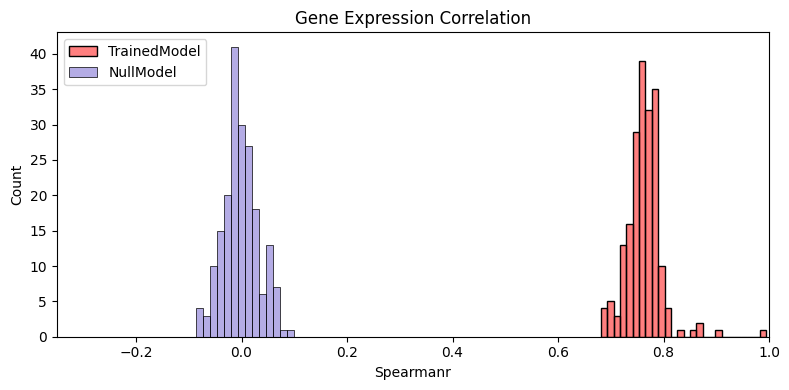

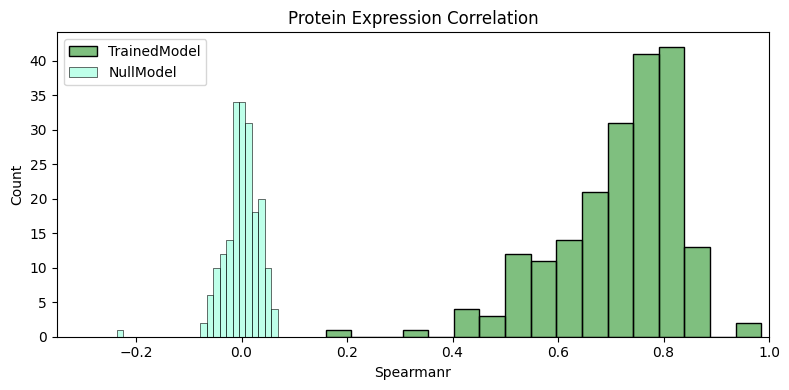

In [541]:
plt.rcParams['figure.figsize'] = (8, 4)
output = integrated_data
a = output.gex_recons.data.cpu().numpy()
b = d11.data.cpu().numpy()
c = output.pex_recons.data.cpu().numpy()
d = d12.data.cpu().numpy()

modelx = SpatialVAE([d11.shape[1], d12.shape[1]], 32).cuda()
modelx.eval()
outputx =  modelx(X=[d11, d12], A=gex.adj_norm, corr=corr)
gex_z = integrated_data.gex_z.data.cpu().numpy()
pex_z = integrated_data.pex_z.data.cpu().numpy()

ax = outputx.gex_recons.data.cpu().numpy()
bx = d11.data.cpu().numpy()
cx = outputx.pex_recons.data.cpu().numpy()
dx = d12.data.cpu().numpy()

corrs = []
for ixs in range(b.shape[1]):
    corrs.append(spearmanr(b[:, ixs], a[:, ixs]).statistic)    
sns.histplot(corrs, color='red', alpha=0.5, label='TrainedModel')
corrs = []
for ixs in range(bx.shape[1]):
    corrs.append(spearmanr(bx[:, ixs], ax[:, ixs]).statistic)    
sns.histplot(corrs, color='slateblue', alpha=0.5, label='NullModel')
plt.title('Gene Expression Correlation')
plt.xlabel('Spearmanr')
plt.xlim(-0.35, 1.0)
plt.legend()
plt.tight_layout()
plt.show()

corrs = []
for ixs in range(d.shape[1]):
    corrs.append(spearmanr(d[:, ixs], c[:, ixs]).statistic)    
sns.histplot(corrs, color='green', alpha=0.5, label='TrainedModel')
corrs = []
for ixs in range(dx.shape[1]):
    corrs.append(spearmanr(dx[:, ixs], cx[:, ixs]).statistic)    
sns.histplot(corrs, color='aquamarine', alpha=0.5, label='NullModel')
plt.title('Protein Expression Correlation')
plt.xlabel('Spearmanr')
plt.xlim(-0.35, 1.0)
plt.legend()
plt.tight_layout()
plt.show()

In [542]:
clustering = LeidenClustering()

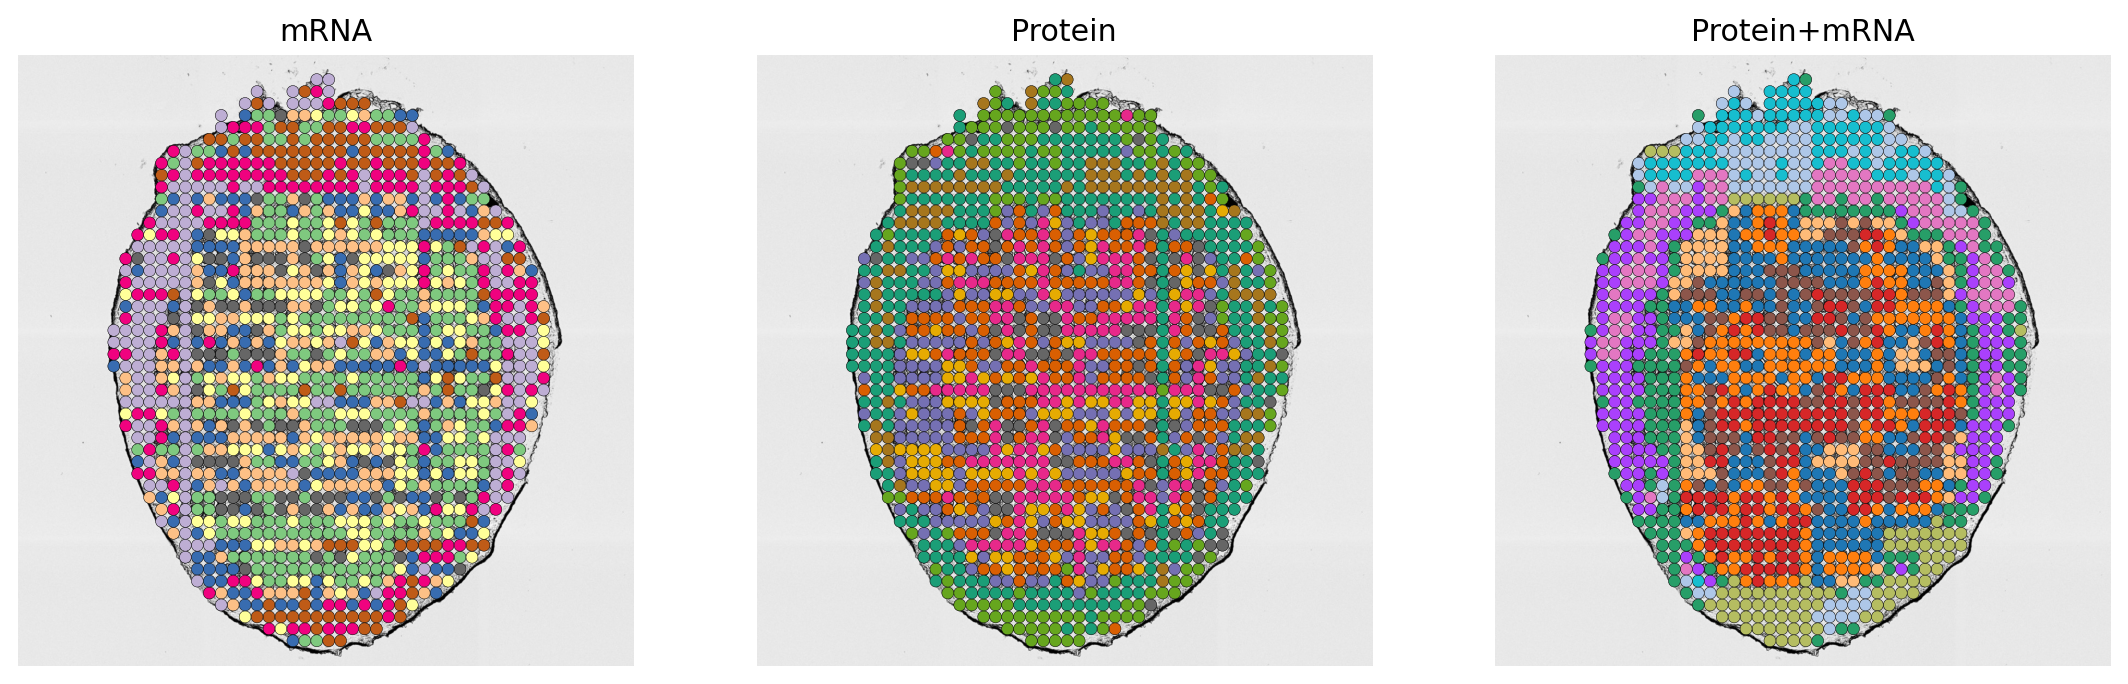

In [564]:
adata = dataset[3] 
sc.pp.filter_genes(adata, min_counts=5)
sc.pp.filter_cells(adata, min_counts=5)

sc.tl.pca(adata)
sc.pp.neighbors(adata)

latent_gex = AnnData(gex_z)
latent_gex.obsm['spatial'] = adata.obsm['spatial']
latent_gex.uns['spatial'] = adata.uns['spatial']
sc.tl.pca(latent_gex)
sc.pp.neighbors(latent_gex)

clustering.fit(gex_z)


adata.obs['spicess'] = clustering.labels_
adata.obs['spicess'] = adata.obs['spicess'].astype('category')

pdata = adata.uns['protein'].copy()
pdata.obsm['spatial'] = adata.obsm['spatial']
pdata.raw = pdata
pdata.X = pdata.X.astype(float)
sc.tl.pca(pdata)
sc.pp.neighbors(pdata)

resolution = 0.6
size = 0.5
linewidth = 0.2
img = True
alpha = 1

sc.tl.leiden(pdata, resolution=resolution)
sc.tl.leiden(latent_gex, resolution=0.9)
sc.tl.leiden(adata, resolution=0.6)

pdata.uns['spatial'] = adata.uns['spatial']
pdata.obs['spicess'] = clustering.labels_
pdata.obs['spicess'] = pdata.obs['spicess'].astype('category')

f, axs = plt.subplots(1, 3, figsize=(15, 15), dpi=180)

sq.pl.spatial_scatter(latent_gex, color=['leiden'], size=size, linewidth=linewidth, edgecolor='black', frameon=False, ax=axs[2], title='Protein+mRNA', alpha=alpha, img=img)
sq.pl.spatial_scatter(pdata, color=['leiden'], size=size, edgecolor='black', linewidth=linewidth, frameon=False, ax=axs[1], title='Protein', alpha=alpha, palette='Dark2', img=img)
sq.pl.spatial_scatter(adata, color=['leiden'], size=size, edgecolor='black', linewidth=linewidth, frameon=False, ax=axs[0], title='mRNA', alpha=alpha, palette='Accent', img=img)
# sq.pl.spatial_scatter(adata, color=None, size=0, frameon=False, ax=axs[-1], title='Tissue', img=True)


axs[0].get_legend().remove()
axs[1].get_legend().remove()
axs[2].get_legend().remove()

# plt.savefig('clusters.png', format='png', dpi=200)
plt.show()

In [202]:
# plt.rcParams['figure.figsize'] = (5, 5)
# ix = 99
# sns.scatterplot(b[:, ix], a[:, ix], color='limegreen')
# plt.title(f'Gene: {adata.var_names[ix]}\nCORR: {spearmanr(b[:, ix], a[:, ix]).statistic:.3f}')
# plt.savefig('protein.svg', dpi=120, format='svg')
# plt.show()

In [539]:
modelx = SpatialVAE([d11.shape[1], d12.shape[1]], 32).cuda()
modelx.eval()
outputx =  modelx(X=[d11, d12], A=gex.adj_norm, corr=corr)
gex_z = integrated_data.gex_z.data.cpu().numpy()
pex_z = integrated_data.pex_z.data.cpu().numpy()

ax = outputx.gex_recons.data.cpu().numpy()
bx = gex.features_pca.data.cpu().numpy()
cx = outputx.pex_recons.data.cpu().numpy()
dx = pex.features_pca.data.cpu().numpy()

In [540]:
corrs = []
for ixs in range(b.shape[1]):
    corrs.append(spearmanr(b[:, ixs], a[:, ixs]).statistic)    
sns.histplot(corrs, color='red', alpha=0.5, label='TrainedModel')
corrs = []
for ixs in range(bx.shape[1]):
    corrs.append(spearmanr(bx[:, ixs], ax[:, ixs]).statistic)    
sns.histplot(corrs, color='blue', alpha=0.5, label='NullModel')
plt.title('Gene Expression Correlation')
plt.xlabel('Spearmanr')
plt.xlim(-0.35, 1.0)
plt.tight_layout()
plt.legend()
plt.savefig('perf_gex.svg', format='svg', dpi=300)
plt.show()

corrs = []
for ixs in range(d.shape[1]):
    corrs.append(spearmanr(d[:, ixs], c[:, ixs]).statistic)    
sns.histplot(corrs, color='red', alpha=0.5, label='TrainedModel')
corrs = []
for ixs in range(dx.shape[1]):
    corrs.append(spearmanr(dx[:, ixs], cx[:, ixs]).statistic)    
sns.histplot(corrs, color='blue', alpha=0.5, label='NullModel')
plt.title('Protein Expression Correlation')
plt.xlabel('Spearmanr')
plt.xlim(-0.35, 1.0)
plt.tight_layout()
plt.legend()
plt.savefig('perf_pex.svg', format='svg', dpi=300)
plt.show()

IndexError: index 196 is out of bounds for axis 1 with size 196